#[Super SloMo](https://people.cs.umass.edu/~hzjiang/projects/superslomo/)
**High Quality Estimation of Multiple Intermediate Frames for Video Interpolation**

## Google Colab Version

I've tried to make this as easy as possible for creatives to use (as opposed to data scientists), the script must be run in Google Colab and should be idempotent, i.e. re-runable.

In [1]:
#@title Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#@title GPU
!nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-a57df2b9-c351-321e-d77e-ff487e147aca)


In [3]:
#@title ffmpeg version
!ffmpeg -version

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-libzmq 

In [4]:
#@title PyTorch version
import torch
print(torch.__version__)
pytorch_version = torch.__version__

1.10.0+cu111


In [5]:
#@title Python Version
import sys
print(sys.version)
python_version = sys.version_info

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


In [6]:
#@title Download the repo
!pip install GitPython

import os.path
import git

working_dir = '/content/working' #@param {type:"string"}
fork = "RichardSlater" #@param ["avinashpaliwal", "RichardSlater"] {allow-input: true}

if not os.path.exists(working_dir):
  git.Repo.clone_from(f'https://github.com/{fork}/Super-SloMo.git', working_dir)

!cd {working_dir}

     |████████████████████████████████| 181 kB 15.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 


In [7]:
#@title Parameters
# Learning Rate. Set `MILESTONES` to epoch values where you want to decrease
# learning rate by a factor of 0.1

INITIAL_LEARNING_RATE = 0.0001 #@param {type:"number"}
MILESTONES = [100, 150]

# Number of epochs to train
EPOCHS = 200 #@param {type:"integer"}

# Choose batchsize as per GPU/CPU configuration
# This configuration works on GTX 1080 Ti
TRAIN_BATCH_SIZE = 6 #@param {type:"integer"}
VALIDATION_BATCH_SIZE =  10#@param {type:"integer"}

# Path to dataset folder containing train-test-validation folders
DATASET_ROOT = "/content/dataset" #@param {type:"string"}

# Path to folder for saving checkpoints
CHECKPOINT_DIR = '/content/drive/MyDrive/Super-SloMo/checkpoints' #@param {type:"string"}

# If resuming from checkpoint, set `trainingContinue` to True and set `checkpoint_path`
TRAINING_CONTINUE = False #@param {type:"boolean"}
CHECKPOINT_PATH = '' #@param {type:"string"}

# Progress and validation frequency (N: after every N iterations)
PROGRESS_ITER = 100 #@param {type:"integer"}

# Checkpoint frequency (N: after every N epochs). Each checkpoint is roughly of size 151 MB.
CHECKPOINT_EPOCH =  10#@param {type:"integer"}

In [8]:
#@title Create folders and download dependencies

import os
import os.path
import urllib.request
import zipfile
import shutil
import subprocess

SourceURL = "http://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/DeepVideoDeblurring_Dataset_Original_High_FPS_Videos.zip" #@param {type:"string"}
AdobeHighFPSDatasetArchive = "/content/drive/MyDrive/Super-SloMo/DeepVideoDeblurring_Dataset_Original_High_FPS_Videos.zip" #@param {type:"string"}
AdobeHighFPSDataset = "/content/drive/MyDrive/Super-SloMo/dataset" #@param {type:"string"}
LogPath = "/content/drive/MyDrive/Super-SloMo/log" #@param {type:"string"}

if not os.path.exists(AdobeHighFPSDatasetArchive):
  urllib.request.urlretrieve(SourceURL, AdobeHighFPSDatasetArchive)

if not os.path.exists(AdobeHighFPSDataset):
  with zipfile.ZipFile(AdobeHighFPSDatasetArchive, 'r') as zip_ref:
    zip_ref.extractall(AdobeHighFPSDataset)

if not os.path.exists(CHECKPOINT_DIR):
  os.mkdir(CHECKPOINT_DIR)

if not os.path.exists(DATASET_ROOT):
  os.mkdir(DATASET_ROOT)

if not os.path.exists(LogPath):
  os.mkdir(LogPath)

if not os.path.exists(os.path.join(DATASET_ROOT, 'train')):
  os.chdir(working_dir)
  p = subprocess.run(['python', 'data/create_dataset.py',
                      '--ffmpeg_dir', '/usr/bin', 
                      '--videos_folder', f'{AdobeHighFPSDataset}/original_high_fps_videos',
                      '--dataset_folder', f'{DATASET_ROOT}',
                      '--dataset', 'adobe240fps'],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, universal_newlines=True)
  print('STDOUT:')
  print(p.stdout)
  print('STDERR:')
  print(p.stderr)

STDOUT:
****************** COMMAND ******************
/usr/bin/ffmpeg -i /content/drive/MyDrive/Super-SloMo/dataset/original_high_fps_videos/720p_240fps_1.mov -c:v mjpeg -vf scale=640:360 -vsync vfr -qscale:v 2 /content/dataset/extracted/720p_240fps_1/%09d.jpg
*********************************************
****************** COMMAND ******************
/usr/bin/ffmpeg -i /content/drive/MyDrive/Super-SloMo/dataset/original_high_fps_videos/GOPR9635.mp4 -c:v mjpeg -vf scale=640:360 -vsync vfr -qscale:v 2 /content/dataset/extracted/GOPR9635/%09d.jpg
*********************************************
****************** COMMAND ******************
/usr/bin/ffmpeg -i /content/drive/MyDrive/Super-SloMo/dataset/original_high_fps_videos/GOPR9637a.mp4 -c:v mjpeg -vf scale=640:360 -vsync vfr -qscale:v 2 /content/dataset/extracted/GOPR9637a/%09d.jpg
*********************************************
****************** COMMAND ******************
/usr/bin/ffmpeg -i /content/drive/MyDrive/Super-SloMo/dataset/origi

In [9]:
#@title Install dependencies

!pip install tensorboardX

import os

os.chdir(working_dir)

%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import model
import dataloader
import matplotlib.pyplot as plt
from math import log10
from IPython.display import clear_output, display
import datetime
from tensorboardX import SummaryWriter

     |████████████████████████████████| 125 kB 14.7 MB/s 


##[TensorboardX](https://github.com/lanpa/tensorboardX)
### For visualizing loss and interpolated frames

In [10]:
#@title Create folders and download dependencies

writer = SummaryWriter(LogPath)

In [11]:
#@title Initialize flow computation and arbitrary-time flow interpolation CNNs.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
flowComp = model.UNet(6, 4)
flowComp.to(device)
ArbTimeFlowIntrp = model.UNet(20, 5)
ArbTimeFlowIntrp.to(device)

UNet(
  (conv1): Conv2d(20, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (down1): down(
    (conv1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (down2): down(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down3): down(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down4): down(
    (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (down5): down(
    (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Co

In [12]:
#@title Initialize Backwarp
trainFlowBackWarp      = model.backWarp(352, 352, device)
trainFlowBackWarp      = trainFlowBackWarp.to(device)
validationFlowBackWarp = model.backWarp(640, 352, device)
validationFlowBackWarp = validationFlowBackWarp.to(device)

In [13]:
#@title Load Datasets
# Channel wise mean calculated on adobe240-fps training dataset
mean = [0.429, 0.431, 0.397]
std  = [1, 1, 1]
normalize = transforms.Normalize(mean=mean,
                                 std=std)
transform = transforms.Compose([transforms.ToTensor(), normalize])

trainset = dataloader.SuperSloMo(root=DATASET_ROOT + '/train', transform=transform, train=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

validationset = dataloader.SuperSloMo(root=DATASET_ROOT + '/validation', transform=transform, randomCropSize=(640, 352), train=False)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=VALIDATION_BATCH_SIZE, shuffle=False)

print(trainset, validationset)

Dataset SuperSloMo
    Number of datapoints: 7542
    Root Location: /content/dataset/train
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )
 Dataset SuperSloMo
    Number of datapoints: 100
    Root Location: /content/dataset/validation
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=[0.429, 0.431, 0.397], std=[1, 1, 1])
                         )



In [14]:
#@title Create transform to display image from tensor
negmean = [x * -1 for x in mean]
revNormalize = transforms.Normalize(mean=negmean, std=std)
TP = transforms.Compose([revNormalize, transforms.ToPILImage()])

Intermediate frame index:  tensor(4)


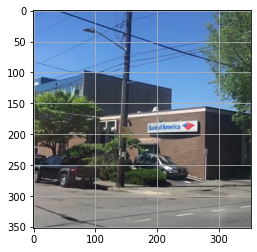

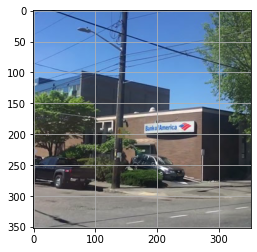

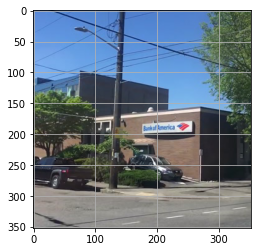

In [15]:
#@title Test the dataset
for trainIndex, (trainData, frameIndex) in enumerate(trainloader, 0):
    frame0, frameT, frame1 = trainData
    print("Intermediate frame index: ", (frameIndex[0]))
    plt.imshow(TP(frame0[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frameT[0]))
    plt.grid(True)
    plt.figure()
    plt.imshow(TP(frame1[0]))
    plt.grid(True)
    break

In [16]:
#@title Utils
plt.rcParams['figure.figsize'] = [15, 3]
def Plot(num, listInp, d):
    a = listInp
    c = []
    for b in a:
        c.append(sum(b)/len(b))
    plt.subplot(1, 2, num)
    plt.plot(c, color=d)
    plt.grid(True)
    
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [17]:
#@title Loss and Optimizer
L1_lossFn = nn.L1Loss()
MSE_LossFn = nn.MSELoss()

params = list(ArbTimeFlowIntrp.parameters()) + list(flowComp.parameters())

optimizer = optim.Adam(params, lr=INITIAL_LEARNING_RATE)
# scheduler to decrease learning rate by a factor of 10 at milestones.
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=0.1)

In [18]:
#@title Initializing VGG16 model for perceptual loss
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_conv_4_3 = nn.Sequential(*list(vgg16.children())[0][:22])
vgg16_conv_4_3.to(device)
for param in vgg16_conv_4_3.parameters():
		param.requires_grad = False

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [19]:
#@title Validation function
def validate():
    # For details see training.
    psnr = 0
    tloss = 0
    flag = 1
    with torch.no_grad():
        for validationIndex, (validationData, validationFrameIndex) in enumerate(validationloader, 0):
            frame0, frameT, frame1 = validationData

            I0 = frame0.to(device)
            I1 = frame1.to(device)
            IFrame = frameT.to(device)
                        
            
            flowOut = flowComp(torch.cat((I0, I1), dim=1))
            F_0_1 = flowOut[:,:2,:,:]
            F_1_0 = flowOut[:,2:,:,:]

            fCoeff = model.getFlowCoeff(validationFrameIndex, device)

            F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
            F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0

            g_I0_F_t_0 = validationFlowBackWarp(I0, F_t_0)
            g_I1_F_t_1 = validationFlowBackWarp(I1, F_t_1)
            
            intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
                
            F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
            F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
            V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
            V_t_1   = 1 - V_t_0
                
            g_I0_F_t_0_f = validationFlowBackWarp(I0, F_t_0_f)
            g_I1_F_t_1_f = validationFlowBackWarp(I1, F_t_1_f)
            
            wCoeff = model.getWarpCoeff(validationFrameIndex, device)
            
            Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
            
            # For tensorboard
            if (flag):
                retImg = torchvision.utils.make_grid([revNormalize(frame0[0]), revNormalize(frameT[0]), revNormalize(Ft_p.cpu()[0]), revNormalize(frame1[0])], padding=10)
                flag = 0
            
            
            #loss
            recnLoss = L1_lossFn(Ft_p, IFrame)
            
            prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
            
            warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(validationFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(validationFlowBackWarp(I1, F_0_1), I0)
        
            loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
            loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
            loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
            
            
            loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
            tloss += loss.item()
            
            #psnr
            MSE_val = MSE_LossFn(Ft_p, IFrame)
            psnr += (10 * log10(1 / MSE_val.item()))
            
    return (psnr / len(validationloader)), (tloss / len(validationloader)), retImg

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


21.9465226357476 35.696597290039065 torch.Size([3, 372, 2610])


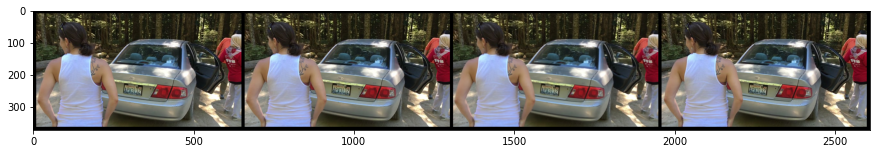

In [20]:
#@title Test validation
a, b, c = validate()
print(a, b, c.size())
plt.imshow(c.permute(1, 2, 0).numpy())

In [21]:
#@title Test validation
if TRAINING_CONTINUE:
    dict1 = torch.load(CHECKPOINT_PATH)
    ArbTimeFlowIntrp.load_state_dict(dict1['state_dictAT'])
    flowComp.load_state_dict(dict1['state_dictFC'])
else:
    dict1 = {'loss': [], 'valLoss': [], 'valPSNR': [], 'epoch': -1}

Epoch:  25


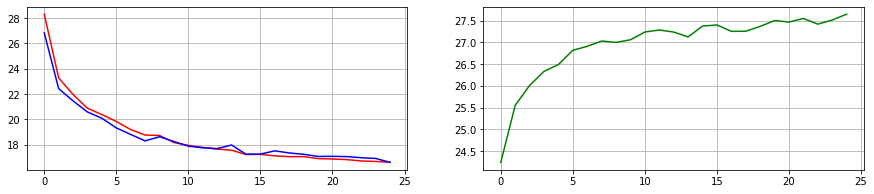

 Loss: 16.137017  Iterations:   99/1257  TrainExecTime: 68.7  ValLoss:17.152537  ValPSNR: 27.5703  ValEvalTime: 6.08 LearningRate: 0.000100
 Loss: 16.609687  Iterations:  199/1257  TrainExecTime: 43.6  ValLoss:17.341665  ValPSNR: 27.3600  ValEvalTime: 6.08 LearningRate: 0.000100
 Loss: 17.374660  Iterations:  299/1257  TrainExecTime: 43.8  ValLoss:16.833262  ValPSNR: 27.7809  ValEvalTime: 6.07 LearningRate: 0.000100
 Loss: 16.264274  Iterations:  399/1257  TrainExecTime: 43.7  ValLoss:16.634362  ValPSNR: 27.6312  ValEvalTime: 6.11 LearningRate: 0.000100
 Loss: 16.601285  Iterations:  499/1257  TrainExecTime: 43.7  ValLoss:16.703534  ValPSNR: 27.6364  ValEvalTime: 6.09 LearningRate: 0.000100
 Loss: 16.423082  Iterations:  599/1257  TrainExecTime: 43.7  ValLoss:16.187025  ValPSNR: 27.7371  ValEvalTime: 6.05 LearningRate: 0.000100
 Loss: 16.499579  Iterations:  699/1257  TrainExecTime: 43.7  ValLoss:16.590488  ValPSNR: 27.6723  ValEvalTime: 6.07 LearningRate: 0.000100
 Loss: 16.527257  It

In [ ]:
#@title Training
import time

start = time.time()
cLoss   = dict1['loss']
valLoss = dict1['valLoss']
valPSNR = dict1['valPSNR']
checkpoint_counter = 0

### Main training loop
for epoch in range(dict1['epoch'] + 1, EPOCHS):
    clear_output()
    print("Epoch: ", epoch)
    
    # Plots
    if (epoch):
        Plot(1, cLoss, 'red')
        Plot(1, valLoss, 'blue')
        Plot(2, valPSNR, 'green')
        display(plt.gcf())
    
    # Append and reset
    cLoss.append([])
    valLoss.append([])
    valPSNR.append([])
    iLoss = 0

    for trainIndex, (trainData, trainFrameIndex) in enumerate(trainloader, 0):
        
		## Getting the input and the target from the training set
        frame0, frameT, frame1 = trainData
        
        I0 = frame0.to(device)
        I1 = frame1.to(device)
        IFrame = frameT.to(device)
        
        optimizer.zero_grad()
        
        # Calculate flow between reference frames I0 and I1
        flowOut = flowComp(torch.cat((I0, I1), dim=1))
        
        # Extracting flows between I0 and I1 - F_0_1 and F_1_0
        F_0_1 = flowOut[:,:2,:,:]
        F_1_0 = flowOut[:,2:,:,:]
        
        fCoeff = model.getFlowCoeff(trainFrameIndex, device)
        
        # Calculate intermediate flows
        F_t_0 = fCoeff[0] * F_0_1 + fCoeff[1] * F_1_0
        F_t_1 = fCoeff[2] * F_0_1 + fCoeff[3] * F_1_0
        
        # Get intermediate frames from the intermediate flows
        g_I0_F_t_0 = trainFlowBackWarp(I0, F_t_0)
        g_I1_F_t_1 = trainFlowBackWarp(I1, F_t_1)
        
        # Calculate optical flow residuals and visibility maps
        intrpOut = ArbTimeFlowIntrp(torch.cat((I0, I1, F_0_1, F_1_0, F_t_1, F_t_0, g_I1_F_t_1, g_I0_F_t_0), dim=1))
        
        # Extract optical flow residuals and visibility maps
        F_t_0_f = intrpOut[:, :2, :, :] + F_t_0
        F_t_1_f = intrpOut[:, 2:4, :, :] + F_t_1
        V_t_0   = torch.sigmoid(intrpOut[:, 4:5, :, :])
        V_t_1   = 1 - V_t_0
        
        # Get intermediate frames from the intermediate flows
        g_I0_F_t_0_f = trainFlowBackWarp(I0, F_t_0_f)
        g_I1_F_t_1_f = trainFlowBackWarp(I1, F_t_1_f)
        
        wCoeff = model.getWarpCoeff(trainFrameIndex, device)
        
        # Calculate final intermediate frame 
        Ft_p = (wCoeff[0] * V_t_0 * g_I0_F_t_0_f + wCoeff[1] * V_t_1 * g_I1_F_t_1_f) / (wCoeff[0] * V_t_0 + wCoeff[1] * V_t_1)
        
        # Loss
        recnLoss = L1_lossFn(Ft_p, IFrame)
            
        prcpLoss = MSE_LossFn(vgg16_conv_4_3(Ft_p), vgg16_conv_4_3(IFrame))
        
        warpLoss = L1_lossFn(g_I0_F_t_0, IFrame) + L1_lossFn(g_I1_F_t_1, IFrame) + L1_lossFn(trainFlowBackWarp(I0, F_1_0), I1) + L1_lossFn(trainFlowBackWarp(I1, F_0_1), I0)
        
        loss_smooth_1_0 = torch.mean(torch.abs(F_1_0[:, :, :, :-1] - F_1_0[:, :, :, 1:])) + torch.mean(torch.abs(F_1_0[:, :, :-1, :] - F_1_0[:, :, 1:, :]))
        loss_smooth_0_1 = torch.mean(torch.abs(F_0_1[:, :, :, :-1] - F_0_1[:, :, :, 1:])) + torch.mean(torch.abs(F_0_1[:, :, :-1, :] - F_0_1[:, :, 1:, :]))
        loss_smooth = loss_smooth_1_0 + loss_smooth_0_1
          
        # Total Loss - Coefficients 204 and 102 are used instead of 0.8 and 0.4
        # since the loss in paper is calculated for input pixels in range 0-255
        # and the input to our network is in range 0-1
        loss = 204 * recnLoss + 102 * warpLoss + 0.005 * prcpLoss + loss_smooth
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        iLoss += loss.item()
               
        # Validation and progress every `PROGRESS_ITER` iterations
        if ((trainIndex % PROGRESS_ITER) == PROGRESS_ITER - 1):
            end = time.time()
            
            psnr, vLoss, valImg = validate()
            
            valPSNR[epoch].append(psnr)
            valLoss[epoch].append(vLoss)
            
            #Tensorboard
            itr = trainIndex + epoch * (len(trainloader))
            
            writer.add_scalars('Loss', {'trainLoss': iLoss/PROGRESS_ITER,
                                        'validationLoss': vLoss}, itr)
            writer.add_scalar('PSNR', psnr, itr)
            
            writer.add_image('Validation',valImg , itr)
            #####
            
            endVal = time.time()
            
            print(" Loss: %0.6f  Iterations: %4d/%4d  TrainExecTime: %0.1f  ValLoss:%0.6f  ValPSNR: %0.4f  ValEvalTime: %0.2f LearningRate: %f" % (iLoss / PROGRESS_ITER, trainIndex, len(trainloader), end - start, vLoss, psnr, endVal - end, get_lr(optimizer)))
            
            cLoss[epoch].append(iLoss/PROGRESS_ITER)
            iLoss = 0
            start = time.time()

    # Increment scheduler count    
    scheduler.step()

    # Create checkpoint after every `CHECKPOINT_EPOCH` epochs
    if ((epoch % CHECKPOINT_EPOCH) == CHECKPOINT_EPOCH - 1):
        dict1 = {
                'Detail':"End to end Super SloMo.",
                'epoch':epoch,
                'timestamp':datetime.datetime.now(),
                'trainBatchSz':TRAIN_BATCH_SIZE,
                'validationBatchSz':VALIDATION_BATCH_SIZE,
                'learningRate':get_lr(optimizer),
                'loss':cLoss,
                'valLoss':valLoss,
                'valPSNR':valPSNR,
                'state_dictFC': flowComp.state_dict(),
                'state_dictAT': ArbTimeFlowIntrp.state_dict(),
                }
        torch.save(dict1, f'{CHECKPOINT_DIR}/SuperSloMo-Python{python_version.major}.{python_version.minor}+{pytorch_version}-{epoch // CHECKPOINT_EPOCH:04d}.ckpt')
        checkpoint_counter += 1
    plt.close('all')